In [44]:
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF
from dfply import *
# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

In [14]:
np.random.seed(1234)
turnout = pd.read_csv("../turnout.csv")
# 80% of the data is in train
train = turnout.sample(frac=.8).reset_index(drop=True)
test = turnout.drop(train.index).reset_index(drop = True)

# Looking at train head
train.head()

,id,age,educate,income,vote,white
0,1749,78,16.0,1.3131,1,1
1,935,72,3.0,0.6765,1,0
2,1034,64,10.0,1.3131,1,1
3,244,80,8.0,1.1839,1,1
4,929,19,14.0,2.9072,1,1


Build a Naive Bayesian Classifier from scratch that tries to predict whether a respondent will vote in a presidential election or not, pr(Vote==1). The classifier must be built from scratch. Do not use a third party ML or statistical package.

Looks like our dependent variable is vote and all the other variables (age, educate, income, white) are independent variables.
Let's first start by subsetting our training data into 2 groups: Vote = 1 and Vote = 0.

In [25]:
# Subsetting data

# The number of training samples
N = train.shape[0]
v1 = (train >>
    mask(X.vote == 1)
)
v0 = (train >>
      mask(X.vote == 0)
)

# Class probabilities
# Calculate the probability for each class (vote or did not vote)
p_v1 = v1.shape[0]/N
p_v0 = v0.shape[0]/N

# Print the probabilities
print(
f"""
Pr(vote = 1): {p_v1}
Pr(vote = 0): {p_v0}
""")


Pr(vote = 1): 0.7425
Pr(vote = 0): 0.2575



Now let us calculate the conditional probabilities for each independent variable: (age, educate, income, white)

In [31]:
# Given vote == 1 (did vote)
# A _ B = P(A|B)
# Out of the vote == 1 group, find age
white1_v1 = v1.query("white == 1").shape[0]/v1.shape[0] # 86.87%
white0_v1 = v1.query("white == 0").shape[0]/v1.shape[0] # 13.13%

# Given vote == 0 (did not vote)
white1_v0 = v0.query("white == 1").shape[0]/v0.shape[0]
white0_v0 = v0.query("white == 0").shape[0]/v0.shape[0]
print(
f"""
P(white = 1 | vote = 1): {white1_v1}
P(white = 0 | vote = 1): {white0_v1}
P(white = 1 | vote = 0): {white1_v0}
P(white = 0 | vote = 0): {white0_v0}
"""
)
#a1_cw1 = cw1.query("authoritarian == 1").shape[0]/v1.shape[0]
#a0_cw1 = cw1.query("authoritarian == 0").shape[0]/v1.shape[0]


P(white = 1 | vote = 1): 0.8686868686868687
P(white = 0 | vote = 1): 0.13131313131313133
P(white = 1 | vote = 0): 0.7985436893203883
P(white = 0 | vote = 0): 0.20145631067961164



In [131]:
# Collect the mean and standard dev. of each conditional distribution
# for each continuous variable
dist_locs = \
{("age",1) :     {'mean':v1.age.mean(),'sd':v1.age.std()},
 ("age",0) :     {'mean':v0.age.mean(),'sd':v0.age.std()},
 ("educate",1) : {'mean':v1.educate.mean(),'sd':v1.educate.std()},
 ("educate",0) : {'mean':v0.educate.mean(),'sd':v0.educate.std()},
 ("income", 1) : {'mean':v1.income.mean(),'sd':v1.income.std()},
 ("income",0) :  {'mean':v0.income.mean(),'sd':v0.income.std()},
 ("white", 1) : {'mean':v1.white.mean(),'sd':v1.white.std()},
 ("white", 0) : {'mean':v0.white.mean(),'sd':v0.white.std()},
}

# Print
pp.pprint(dist_locs)

{('age', 0): {'mean': 42.601941747572816, 'sd': 19.147825402160812},
 ('age', 1): {'mean': 46.32491582491583, 'sd': 16.924844588853727},
 ('educate', 0): {'mean': 10.62864077669903, 'sd': 3.3043810919835317},
 ('educate', 1): {'mean': 12.558922558922559, 'sd': 3.2957141274443202},
 ('income', 0): {'mean': 2.738161893203883, 'sd': 2.242991372933763},
 ('income', 1): {'mean': 4.229461952861953, 'sd': 2.848208991067699},
 ('white', 0): {'mean': 0.7985436893203883, 'sd': 0.4015757472901718},
 ('white', 1): {'mean': 0.8686868686868687, 'sd': 0.3378847322122334}}


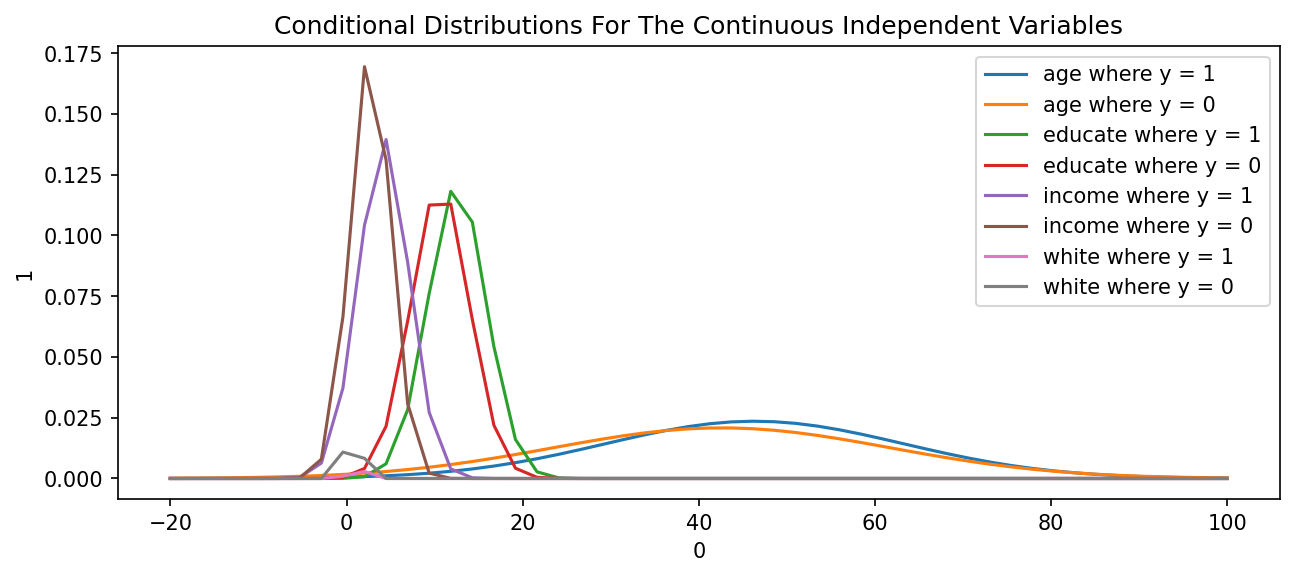

In [132]:
# Plot with seaborn
plt.figure(figsize=(10,4),dpi=150)
# for every key in dist_locs
d = None
for key in dist_locs.keys():
    #print(f"""key = {key}""")
    #print(f"""value = {dist_locs[key]}""")
    
    value = dist_locs[key]
    d = pd.DataFrame([[i, st.norm(value['mean'], value['sd']).pdf(i)] for i in np.linspace(-20,100)])
    # 2 columns: first one is the mean, 2nd one is the value
    #print(d)
    ax = sns.lineplot(x = d.iloc[:,0],y = d.iloc[:, 1],label=f"{key[0]} where y = {key[1]}")
    ax.set_title("Conditional Distributions For The Continuous Independent Variables")

In [133]:
# For 1 row
myID, myAge, myEducate, myIncome, myVote, myWhite = train.iloc[3,:]
print(myID, myAge, myEducate, myIncome, myVote, myWhite)

244.0 80.0 8.0 1.1839 1.0 1.0


In [142]:
# Prediction for the 1 class
# For vote = 1
# Creating a normal random distribution of a specified mean and sd
# depending on the independent variable
# So for A, you can somehow find the PDF of myAge for that one observation...
a = st.norm(dist_locs[("age",1)]['mean'], dist_locs[("age",1)]['sd']).pdf(myAge)
b = st.norm(dist_locs[("educate",1)]['mean'], dist_locs[("educate",1)]['sd']).pdf(myEducate)
c = st.norm(dist_locs[("income",1)]['mean'], dist_locs[("income",1)]['sd']).pdf(myIncome)
#d = st.norm(dist_locs[("white",1)]['mean'], dist_locs[("white",1)]['sd']).pdf(myWhite)
d = p_v1
#e = white1_v1
e = st.norm(dist_locs[("white",1)]['mean'], dist_locs[("white",1)]['sd']).pdf(myWhite)

#c = p_v1
# Multiply together..
pr_v1 = a * b * c * d *e

# Prediction for the 0 class (vote = 0)
a = st.norm(dist_locs[("age",0)]['mean'], dist_locs[("age",0)]['sd']).pdf(myAge)
b = st.norm(dist_locs[("educate",0)]['mean'], dist_locs[("educate",0)]['sd']).pdf(myEducate)
c = st.norm(dist_locs[("income",0)]['mean'], dist_locs[("income",0)]['sd']).pdf(myIncome)
#d = st.norm(dist_locs[("white",0)]['mean'], dist_locs[("white",1)]['sd']).pdf(myWhite)
d = p_v0
#e = white1_v0
e = st.norm(dist_locs[("white",0)]['mean'], dist_locs[("white",0)]['sd']).pdf(myWhite)
pr_v0 = a * b * c * d * e

print(
f'''
    Pr(vote == 1| X): {pr_v1}
    Pr(vote == 0| X): {pr_v0}
''')



    Pr(vote == 1| X): 9.733822442603499e-06
    Pr(vote == 0| X): 8.588785697503298e-06



0.9884354611744177

In [153]:
def predict(data,dist_locs):
    '''
    Given data and the means/std of each independent continuous variable,
    predicts the dependent variable.
    
    @param data the dataframe to look at
    @param dist_locs the dictionary filled with means and stds of each independent continuous variable
    @return the dataframe filled with marginal probabilities for each observation for each class, and prediction
    '''
    store_preds = []
    for i,row in data.iterrows():
        # i = index
        # row = the row
        # Get the predictions using a Gaussan distribution
        pr_0 = 1
        pr_1 = 1
        # in this case, the len(row) = 6, or 6 columns
        # start at index = 1 beacuse we don't want to find probabiliy of id
        for j in range(1,len(row)):
            if row.index[j] != "vote":
                #print(j)
                pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                                dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
                pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                                dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        
        # And then multiply with the class..
        pr_0 *= p_v0
        pr_1 *= p_v1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

predTrain = predict(train, dist_locs)


In [155]:
# Predicted output
predTrain.head(7)

,pr_0,pr_1,pred
0,3.984875e-06,1.935371e-05,1
1,2.224761e-07,2.785280e-08,0
2,4.337782e-05,8.247596e-05,1
3,8.588786e-06,9.733822e-06,1
4,2.797497e-05,7.201115e-05,1
5,2.615106e-06,1.553231e-06,0
6,5.286035e-05,9.446765e-05,1


In [ ]:
# Now accuracy time
accuracy_train = sum(train.vote == predTrain.pred)/train.shape[0]
accuracy_train

Wow we suck.
Let's test our accuracy on the testing data

In [157]:
predTest = predict(test, dist_locs)
# See how many times the vote column matches the predicted column
accuracyTest = sum(test.vote == predTest.pred)/test.shape[0]
accuracyTest

0.7125

Wow we still suck on predicting the test values for vote.

# Analysis

We used calculated class probabilities for continuous independent variables and conditional probabilities for discrete independent variables. 

In [124]:
for i, row in train.iterrows():
    print(i)
    print(row)
    print(row.index[i])


0
id         1749.0000
age          78.0000
educate      16.0000
income        1.3131
vote          1.0000
white         1.0000
Name: 0, dtype: float64
id
1
id         935.0000
age         72.0000
educate      3.0000
income       0.6765
vote         1.0000
white        0.0000
Name: 1, dtype: float64
age
2
id         1034.0000
age          64.0000
educate      10.0000
income        1.3131
vote          1.0000
white         1.0000
Name: 2, dtype: float64
educate
3
id         244.0000
age         80.0000
educate      8.0000
income       1.1839
vote         1.0000
white        1.0000
Name: 3, dtype: float64
income
4
id         929.0000
age         19.0000
educate     14.0000
income       2.9072
vote         1.0000
white        1.0000
Name: 4, dtype: float64
vote
5
id         1599.0000
age          72.0000
educate       4.0000
income        0.5813
vote          0.0000
white         1.0000
Name: 5, dtype: float64
white
6
id         1838.0000
age          23.0000
educate      12.0000
income  

IndexError: index 6 is out of bounds for axis 0 with size 6

Now we predict.
Remember, we have to predict by:
    P(x1 | y)P(x2 | y) * ... * P(xn | y)P(y)
    
Let's predict whether someone will vote given it is White.

In [ ]:
prob_cw1 = white1_v1 * a0_v1 * p_v1
prob_cw0 = white1_v0 * a0_v0 * p_v0

print(f"""
Pr(cw = 1) = {prob_cw1}
Pr(cw = 0) = {prob_cw0}
""")